In [1]:
import os
import medusa
from pickle import load
import pandas as pd
import json
import numpy

import matplotlib.pyplot as plt
import matplotlib

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.manifold import MDS

from skbio.stats.ordination import pcoa
from skbio.stats.distance import DissimilarityMatrix

In [2]:
# load the gene knockout dataframes
gene_knockout_results = {}    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    gene_knockout_results[species] = pd.read_csv(
        '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)

In [3]:
# load the ensembles, which we will need later.
# load all ensembles
ensembles = {}
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

In [4]:
# Get the ensemble feature states for each species, which will be used as input
# to regression with principle coordinates as output.
feature_frames = {}
for species in ensembles.keys():
    ensemble = ensembles[species]
    # Grab the features and states for the ensemble and convert to a dataframe
    feature_dict = {}
    for feature in ensemble.features:
        feature_dict[feature.id] = feature.states
    feature_frame = pd.DataFrame.from_dict(feature_dict)

    # Convert to a boolean dataframe for faster computation
    # (0 values become False, all others become True (i.e. active features))
    feature_frames[species] = feature_frame.astype(bool)

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


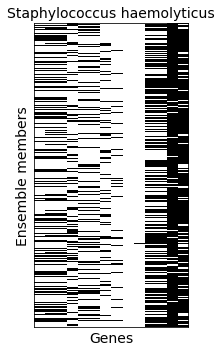

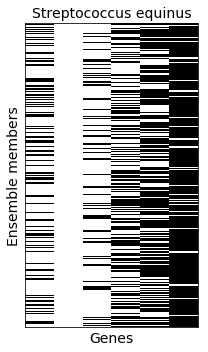

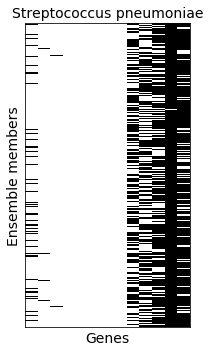

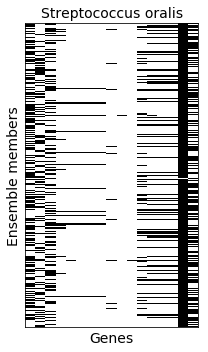

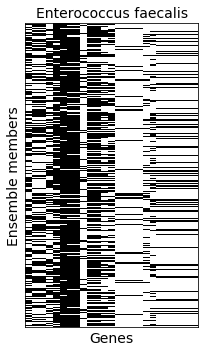

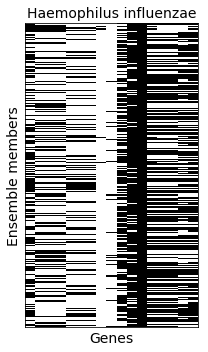

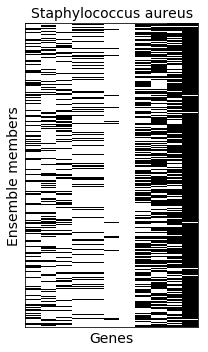

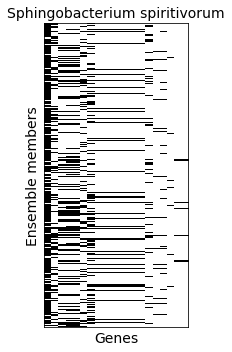

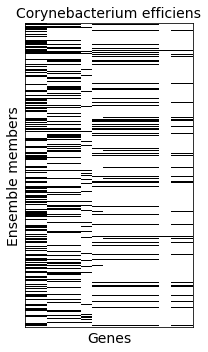

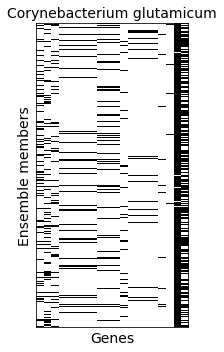

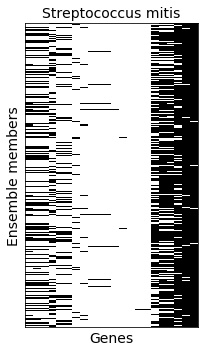

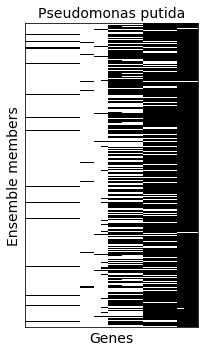

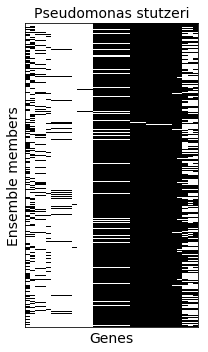

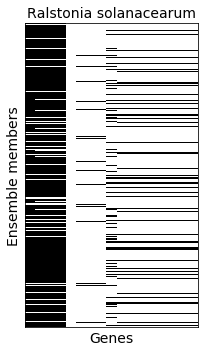

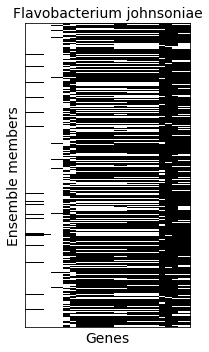

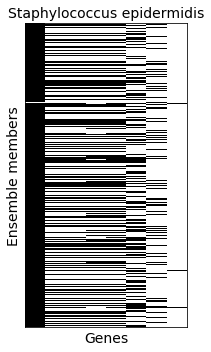

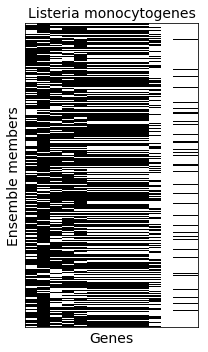

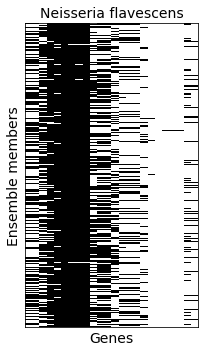

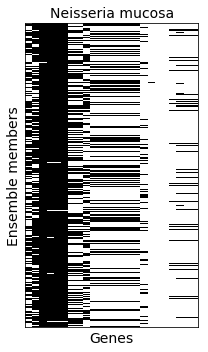

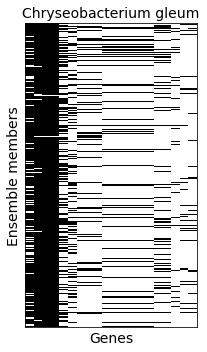

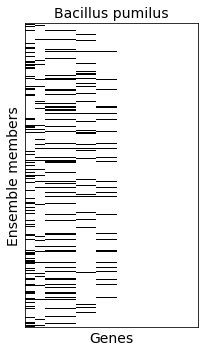

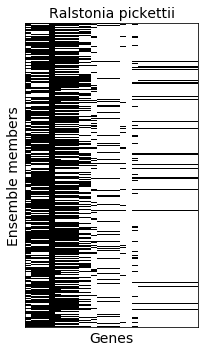

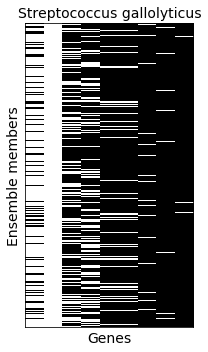

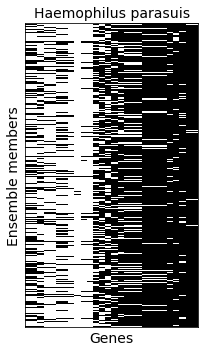

In [5]:
for species in gene_knockout_results.keys():
    if species not in exclude:
        if len(gene_knockout_results[species].keys()) > 200: # REMOVE THIS AFTER WE'VE FULLY CONVERTED TO DEEP ENSEMBLES
            # for this species, create a dataframe that has genes that never had an effect
            # on growth removed for visualization
            plotframe = gene_knockout_results[species]


            # normalize each ensemble's knockout results by dividing by it's max growth rate
            #plotframe = plotframe.div(plotframe.max(axis=0), axis=1)

            # binarize the data

            #plotframe = plotframe.loc[(plotframe > 1E-8).sum(axis=1) < len(plotframe.columns)]
            # Also remove reactions that were essential in all members
            #plotframe = plotframe.loc[(plotframe < 1E-8).sum(axis=1) != len(plotframe.columns)]

            plotframe = plotframe > 1E-6
            plotframe = plotframe.loc[(plotframe == 0).sum(axis=1) != len(plotframe.columns)]
            plotframe = plotframe.loc[(plotframe == 1).sum(axis=1) < len(plotframe.columns)]
            plotvals = plotframe.values

            # reorder by heirarchical clustering of genes
            dgram = dendrogram(linkage(pdist(plotvals,metric='hamming')),labels=plotframe.index,no_plot=True)
            plotframe = plotframe.reindex(dgram['ivl'])
            plotvals = plotframe.values

            #plotvals = plotvals/plotvals.max()
            rxn_labels = plotframe.index

            # Black cells are non-essential, white cells are essential.
            fig, ax = plt.subplots()
            im = ax.imshow(plotvals.T,cmap='binary')
            ax.set_ylabel('Ensemble members',size=14)
            ax.set_xlabel('Genes',size=14)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(species,size=14)
            ax.set_aspect('auto')
            fig.set_size_inches(3,5)
            fig.tight_layout()
            fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.png')
            fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.svg')

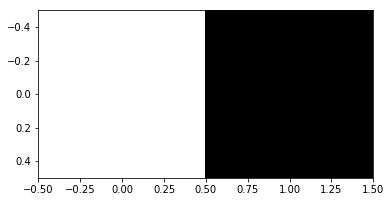

In [6]:
fig,ax=plt.subplots()
ax.imshow([[False,True]],cmap='binary')

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -7.340923374424125 and the largest is 32.24206535510712.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue 

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.606330614698182 and the largest is 73.12798756679273.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue 

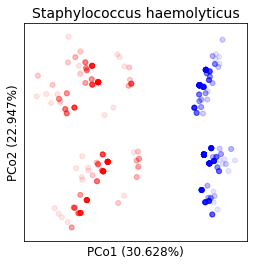

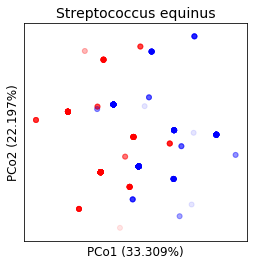

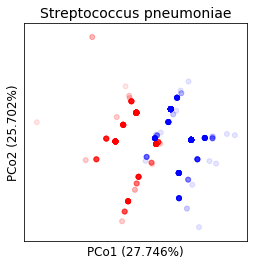

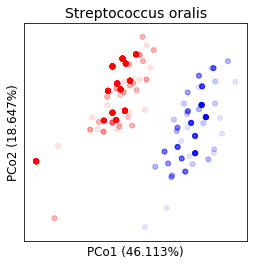

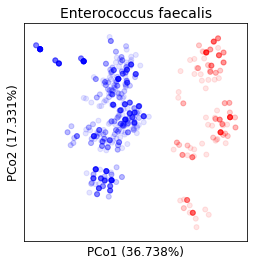

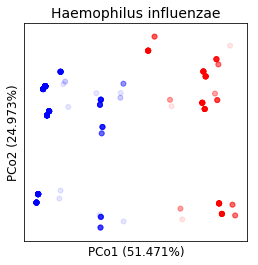

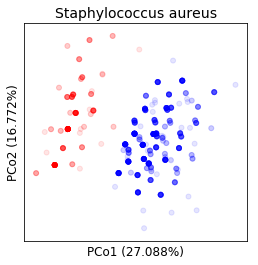

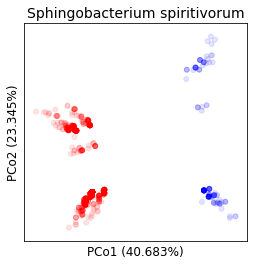

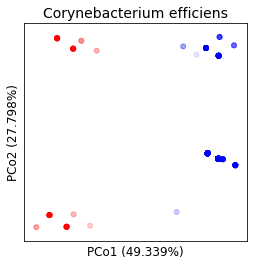

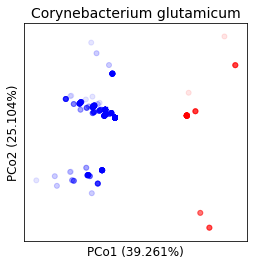

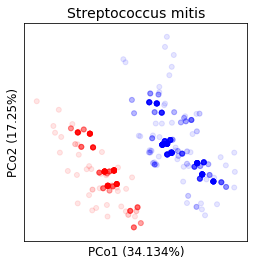

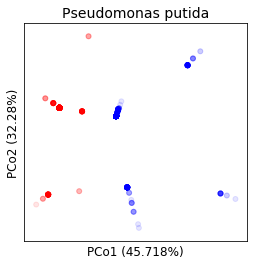

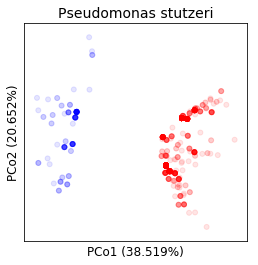

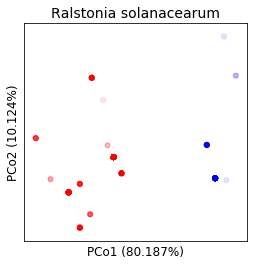

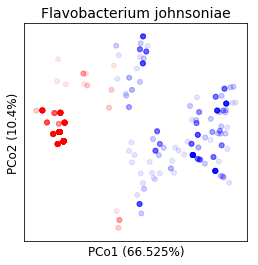

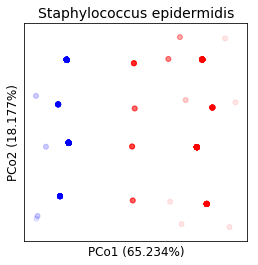

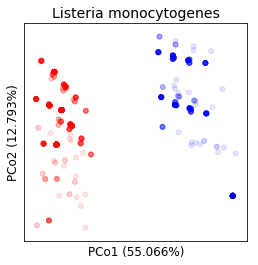

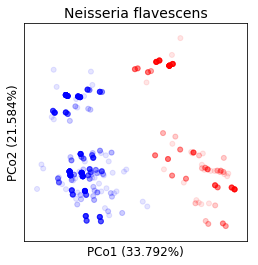

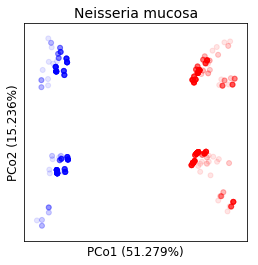

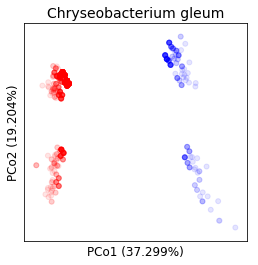

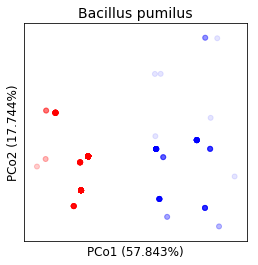

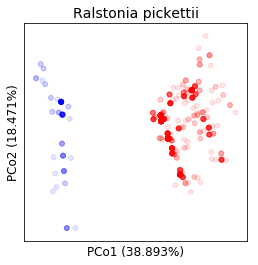

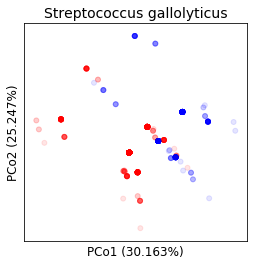

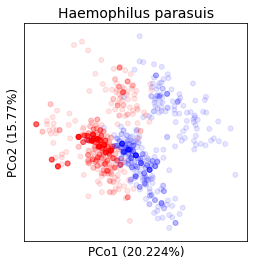

In [7]:
# Calculate the gene knockout distance between ensemble members, perform PCA on the distance
# matrix, then regress on PC1.
pipe_w_scale = make_pipeline(StandardScaler(), PCA(n_components=2))
# mds_pipe = make_pipeline(MDS(n_components=2, 
#                              metric=True, 
#                              n_init=4, 
#                              max_iter=300,
#                              eps=0.001,
#                              verbose=2,
#                              dissimilarity='euclidean'))
#regress_pipe = make_pipeline(RandomForestRegressor(n_estimators=100, oob_score=True))
pc1_classifiers = {}
pc2_classifiers = {}
r2 = {}
for species in gene_knockout_results.keys():
    if species not in ["Stenotrophomonas maltophilia"]:
        if len(gene_knockout_results[species].keys()) > 200: # REMOVE AFTER CONVERTING TO DEEP ENSEMBLES
            df_for_pca = gene_knockout_results[species]

            df_for_pca = df_for_pca > 1E-6
            df_for_pca = df_for_pca.loc[(df_for_pca == False).sum(axis=1) != len(df_for_pca.columns)]
            df_for_pca = df_for_pca.loc[(df_for_pca == True).sum(axis=1) < len(df_for_pca.columns)]
            df_for_pca = df_for_pca.T

            # perform kmeans clustering on the gene profiles to determine
            # the two clusters with maximal variance
            clust = KMeans(n_clusters = 2).fit(df_for_pca.values)
            
            #mds_coords = mds_pipe.fit_transform(df_for_pca)
            pca_input = DissimilarityMatrix(squareform(pdist(df_for_pca,metric="hamming")),ids=df_for_pca.index)
            pcoa_result = pcoa(pca_input, number_of_dimensions=3)
    #         pipe_w_scale.fit(pca_input)

    #         pc1 = pipe_w_scale.transform(pca_input)[:,0]
    #         pc2 = pipe_w_scale.transform(pca_input)[:,1]

            # Add scores for each sample back to the dataframes
            df_for_pca['PCo1'] = pcoa_result.samples['PC1'].values#mds_coords[:,0]#pc1
            df_for_pca['PCo2'] = pcoa_result.samples['PC2'].values#mds_coords[:,1]#pc2
            df_for_pca['cluster'] = clust.labels_
            #print(pcoa_result.samples['PC1'])
            #print(df_for_pca['PCo1'])


            # grab the ensembles feature frame, fit the RF regressor
            feature_frame = feature_frames[species]
            input_cols = feature_frame.columns
            df_for_pca = df_for_pca.merge(feature_frame,left_index=True,right_index=True)
            # perform regression using random forest
            pc1_classifiers[species] = RandomForestClassifier(n_estimators=500, oob_score=True).fit(
                df_for_pca[input_cols],df_for_pca['cluster'])

            #pc2_classifiers[species] = RandomForestClassifier(n_estimators=100, oob_score=True).fit(
            #    df_for_pca[input_cols],df_for_pca['PCo2'])


            # get variance explained for PC1/PC2
            pc1_var = pcoa_result.proportion_explained[0]#pipe_w_scale.named_steps.pca.explained_variance_[0]
            pc2_var = pcoa_result.proportion_explained[1]#pipe_w_scale.named_steps.pca.explained_variance_[1]

            fig, ax = plt.subplots()
            colors = ['red','blue']
            clust_color = [colors[i] for i in df_for_pca['cluster']]
            cmap=matplotlib.colors.ListedColormap(colors)
            ax.scatter(df_for_pca['PCo1'],df_for_pca['PCo2'],marker='o',
                    c=clust_color,cmap=cmap,alpha = 0.1,s=25)
            ax.set_title(species,fontsize=14)
            ax.set_xlabel('PCo1 (%s%%)' % str(numpy.round(100*pc1_var,decimals=3)), fontsize=12)
            ax.set_ylabel('PCo2 (%s%%)' % str(numpy.round(100*pc2_var,decimals=3)), fontsize=12)
            ax.axes.get_yaxis().set_ticks([])
            ax.axes.get_xaxis().set_ticks([])
            fig.set_size_inches(4,4)
            fig.savefig('../results/gene_knockout_pcoa_plots/'+species+'_gene_ko_pcoa.png')
            fig.savefig('../results/gene_knockout_pcoa_plots/'+species+'_gene_ko_pcoa.svg')
            #plt.legend(bbox_to_anchor=(1,1))

            # Save the classifier importances and R^2
            pd.DataFrame(pc1_classifiers[species].feature_importances_,
                                            index=feature_frames[species].columns).sort_values(
                                            by=0,ascending=False).to_csv(
                                            '../results/regressor_results/'+species+'_pco1_importance.csv',sep=',')
#             pd.DataFrame(pc2_classifiers[species].feature_importances_,
#                                             index=feature_frames[species].columns).sort_values(
#                                             by=0,ascending=False).to_csv(
#                                             '../results/regressor_results/'+species+'_pco2_importance.csv',sep=',')
            
            # save the cluster membership information
            df_for_pca['cluster'].to_csv('../results/regressor_results/'+species+'_clusters.csv',sep=',')
    
            r2[species] = {}
            r2[species]['PCo1'] = pc1_classifiers[species].oob_score_
            #r2[species]['PCo2'] = pc2_classifiers[species].oob_score_

# Save the performance results
with open('../results/regressor_results/perfomance.json','w') as outfile:
    json.dump(r2,outfile)

In [8]:
r2

{'Bacillus pumilus': {'PCo1': 1.0},
 'Chryseobacterium gleum': {'PCo1': 0.99090909090909096},
 'Corynebacterium efficiens': {'PCo1': 0.99630996309963105},
 'Corynebacterium glutamicum': {'PCo1': 0.9989806320081549},
 'Enterococcus faecalis': {'PCo1': 1.0},
 'Flavobacterium johnsoniae': {'PCo1': 0.97697697697697694},
 'Haemophilus influenzae': {'PCo1': 1.0},
 'Haemophilus parasuis': {'PCo1': 0.99299299299299304},
 'Listeria monocytogenes': {'PCo1': 1.0},
 'Neisseria flavescens': {'PCo1': 1.0},
 'Neisseria mucosa': {'PCo1': 0.99487704918032782},
 'Pseudomonas putida': {'PCo1': 0.99307159353348728},
 'Pseudomonas stutzeri': {'PCo1': 0.99398194583751254},
 'Ralstonia pickettii': {'PCo1': 0.99585921325051763},
 'Ralstonia solanacearum': {'PCo1': 0.9889001009081736},
 'Sphingobacterium spiritivorum': {'PCo1': 0.99298597194388782},
 'Staphylococcus aureus': {'PCo1': 0.995},
 'Staphylococcus epidermidis': {'PCo1': 0.98098098098098097},
 'Staphylococcus haemolyticus': {'PCo1': 0.984969939879759